In [1]:
import torch
from transformers import AutoTokenizer, AutoModel, PreTrainedModel, AutoModelForMaskedLM,  DataCollatorForLanguageModeling
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import AdamW
import os
from sklearn.model_selection import train_test_split
from torchmetrics.regression import R2Score

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Functions

## Model functions

In [2]:
# Refer to task 1
class MoLFormerMLMWithRegressionHead(PreTrainedModel):
    def __init__(self, pretrained_model, config=None):
        if config is None:
            config = pretrained_model.config
        super().__init__(config)
        self.backbone = pretrained_model
        hidden_size = self.backbone.config.hidden_size
        self.regression_head = nn.Linear(hidden_size, 1)
        self.config = config

    def forward(self, input_ids, attention_mask=None):
        outputs = self.backbone(input_ids=input_ids, 
                               attention_mask=attention_mask,
                               output_hidden_states=True)  # MLM needs hidden states explicitly
        last_hidden_state = outputs.hidden_states[-1]  # Access last layer’s hidden states
        cls_hidden_state = last_hidden_state[:, 0, :]
        output = self.regression_head(cls_hidden_state)
        return output.squeeze(-1)
    
class MoLFormerWithRegressionHead(PreTrainedModel):
    def __init__(self, pretrained_model, config=None):
        # If no config is provided, use the pretrained model's config
        if config is None:
            config = pretrained_model.config
            
        super().__init__(config)  # Initialize with config
        self.backbone = pretrained_model  # Use the pre-trained MoLFormer model as the backbone
        
        # Get the hidden size from the config
        hidden_size = self.backbone.config.hidden_size
        
        # Define a regression head: Fully connected layer that outputs a single value
        self.regression_head = nn.Linear(hidden_size, 1)
        
        # Ensure the backbone's parameters are part of this model's parameters
        self.config = config

    def forward(self, input_ids, attention_mask):
        # Forward pass through the pre-trained model
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get the last hidden state of the [CLS] token
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, sequence_length, hidden_size)
        
        # We use the hidden state corresponding to the [CLS] token for regression
        cls_hidden_state = last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)
        
        # Pass through the regression head
        output = self.regression_head(cls_hidden_state)  # Shape: (batch_size, 1)
        
        # Flatten the output to (batch_size,) for regression
        return output.squeeze(-1)

In [5]:
class Dataset(Dataset):
    def __init__(self, data):
        self.smiles = data['SMILES'].values
        self.label = data['label'].values
    
    def __len__(self):
        return(len(self.smiles))
    
    def __getitem__(self, idx):
        smile = self.smiles[idx]
        value = self.label[idx]
        
        return smile,value

In [6]:
def collate_fn(batch):
    """
    Collate function for the DataLoader
    """
    smile, value = zip(*batch)
    return list(smile), list(value)

## Task2 functions


In [31]:
def calc_grad(smile, value):
    """
    Computes the gradient with respect to an input
    """
    
    value = value.float().to(device)
    smile = token(smile, padding = True, return_tensors = 'pt').to(device)
    
    # Pass 1 training point forward        
    optimizer.zero_grad()
    predict = model(**smile)
    loss = criterion(predict , value)
    loss.backward(create_graph = True)
    
    # Get the grads for the training point
    grad = [param.grad.clone() for param in model.parameters() if param.grad is not None]
    
    return grad

In [ ]:
def lissa(s1, s2, model, ihvp, damp_fac: float = 0.001):
    """
    Computes the LiSSA approximation to get the hessian inverse.
    This implementation is based on 
        Second-Order Stochastic Optimization for Machine Learning in Linear Time
        Understanding Black-box Predictions via Influence Function

    Args:
        s1 (int): Number of Hessian inverse estimators to create
        s2 (int): The depth of the  Taylor expansion in estimators
        ihvp (lis[torch.Tensor]): List of torch.zeros. Shape must be same as grads from the model
        damp_fac (float, optional): Damping factor to be used in the calculation. Defaults to 0.001.

    Returns:
        list[torch.Tensor]: Hessian inverse approximation
    """
    
    parameters = [p for p in model.parameters() if p.grad is not None]
    # No of hessian inverse estimators
    for j in range(s1):
        z = random.choice(list(ext2_loader))
        
        # No. of iterations for each estimator
        for i in range(s2):
            match i:
                case 0:
                    # v is the loss grad for a training point
                    v = calc_grad(smile = z[0], value = z[1])
                    
                    # At the start of h_inv recursion, h_inv*v = v
                    h_inv = calc_grad(smile = z[0], value = z[1])
                    
                case _:
                    # From the next iteration, random training points are chosen and grad calculated
                    # We take 16 random points and get the avged grad
                    t_point = random.choice(list(ext1_loader))
                    t_point_grad = calc_grad(smile = t_point[0], value = t_point[1])
                    
                    
                    # This is the recursion
                    # h_inv(j)v = v + (I - grad^2) * h_inv(j-1)v
                    
                    #           = v + (h_inv(j-1)v - grad^2*h_inv(j-1)v)
                    #                                This is HVP. Calculcating it
                    # model parameters should be updated based on the training points being used.
                    parameters = [p for p in model.parameters() if p.grad is not None]
                    # https://stackoverflow.com/questions/74889490/a-faster-hessian-vector-product-in-pytorch
                    # Kind of found about doing HVP with grad from here
                    hvp = torch.autograd.grad(outputs=t_point_grad, inputs=parameters,
                                            grad_outputs=h_inv, retain_graph=True)
                    
                    #           = v + (h_inv(j-1)v - h_inv(j-1)v*grad^2)
                    #                  Computing the subtraction
                    subt = [h_inv[i] - hvp[i]*damp_fac for i in range(len(h_inv))]
                    
                    #           = v + (h_inv(j-1)v - h_inv(j-1)v*grad^2)
                    #             Computing the addition
                    h_inv = [v[i] + subt[i] for i in range(len(v))]
        
        # In each iteration,
        ihvp = [i+j for i,j in zip(ihvp,h_inv)]
        
    ihvp = [i/s1 for i in ihvp]
    return ihvp
        

# Initialization

In [9]:
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
dataset = load_dataset(DATASET_PATH)
data = dataset['train'].to_pandas()

In [ ]:
EXTERNAL_DATA_LOCATION = 'External-Dataset_for_Task2.csv'
ext_data = pd.read_csv(EXTERNAL_DATA_LOCATION)
ext_data.rename({'Label' : 'label'}, inplace = True, axis = 1)

In [ ]:
# Cannot upload models
# This is the path for the pretrainedMLM model which was fine tuned in task1
MODEL_NAME = "molformer_pretrainedMLM" 
#MODEL_NAME = 'ibm/MoLFormer-XL-both-10pct'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True).to(device)
model = MoLFormerMLMWithRegressionHead(pre_model).to(device)
token = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

In [16]:
lr = 0.001
wt_decay = 1e-5
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wt_decay)

In [13]:
ext_df   = Dataset(ext_data)
# Used inside LiSSA. The paper mentions using batch avg grad is better
ext1_loader   = DataLoader(ext_df, batch_size = 16)

# Used to find the influence of each point
ext2_loader   = DataLoader(ext_df, batch_size = 1)

# Algorithm

In [33]:
influence_list = []

for z in tqdm(ext2_loader):
    # Calculate the grad for the point for which the influence is being calculated
    z_grad = calc_grad(smile = z[0], value = z[1])
    
    # initiate the Hessian inverse
    ihvp = [torch.zeros_like(i) for i in z_grad]
    ihvp = lissa(s1 = 5, s2 = 10, ihvp = ihvp, model = model)
    
    # Multiplying the Hessian inverse by the 
    influence = sum([(g * i).sum().item() for g, i in zip(ihvp, z_grad)])
    
    influence_list.append([z[0][0], float(z[1]), influence])

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [52:39<00:00, 10.53s/it]


# Results

In [104]:
influence_df = pd.DataFrame(influence_list, columns = ['SMILE', 'label', 'Influence'])
influence_df.to_csv('Influence.tsv', sep = '\t', index = False)

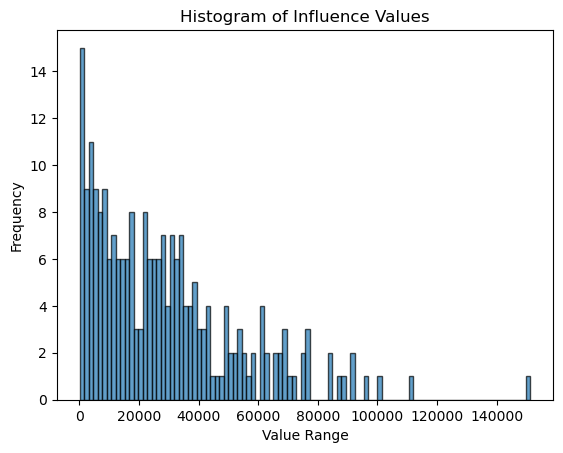

In [24]:
influence_df0 = influence_df["Influence"][influence_df["Influence"] > 0]
# Influence histogram
plt.hist(influence_df0, bins=100, edgecolor='black', alpha=0.7)  # Adjust bins as needed
plt.xlabel("Value Range")
plt.ylabel("Frequency")
plt.title("Histogram of Influence Values")
plt.show()

In [ ]:
influence_df = influence_df[influence_df["Influence"] > 0]
influence_df['len'] = influence_df['SMILE'].str.len()

Text(0.5, 1.0, 'Length vs Influence')

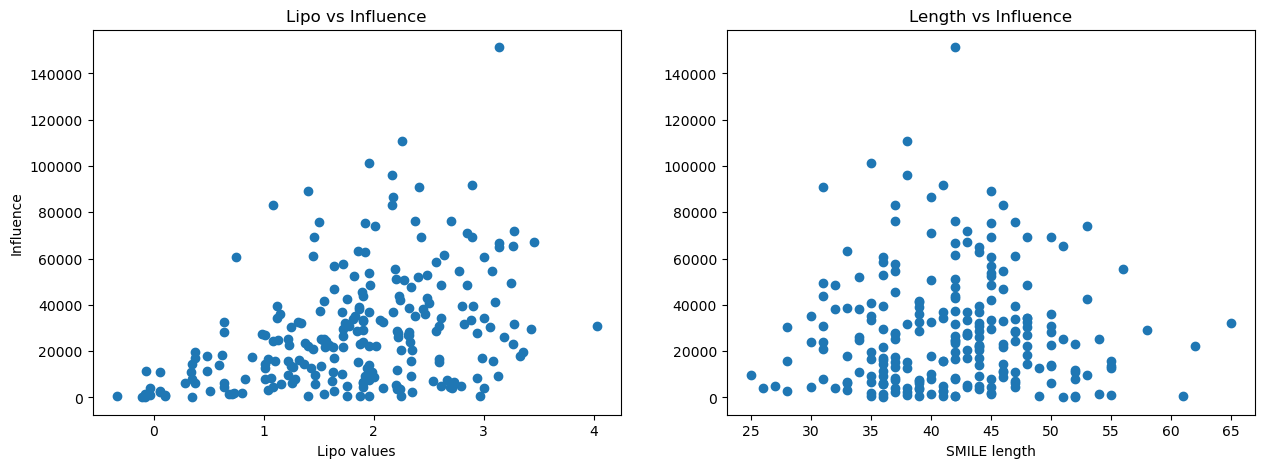

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(influence_df['label'], influence_df['Influence'])
ax1.set_xlabel('Lipo values')
ax1.set_ylabel('Influence')
ax1.set_title('Lipo vs Influence')

ax2.scatter(influence_df['len'], influence_df['Influence'])
ax2.set_xlabel('SMILE length')
#ax2.set_ylabel('Influence')
ax2.set_title('Length vs Influence')

Choosing an appropriate cutoff based on the histogram. There is a dropoff at 50000. We will consider this as our cutoff.

In [106]:
threshold = 50000
influence_best_df = influence_df[influence_df["Influence"] > threshold]

In [107]:
influence_best_df.to_csv('Best_influence.tsv', sep = '\t', index = False)

Combining these best points to the training dataset

In [108]:
influence_best_df = influence_best_df[['SMILE', 'label']]
influence_best_df.rename({'SMILE' : 'SMILES'}, axis = 1, inplace = True)

combined_df = pd.concat([data, influence_best_df], axis = 0)
combined_df.to_csv('new_train_data.tsv', sep = '\t', index = False)

# Fine-tuning on MLM Task

Refer to Task1. These functions/classes taken directly from Task1

In [10]:
NEW_DATA_LOCATION = 'new_train_data.tsv'
ext_data = pd.read_csv(NEW_DATA_LOCATION, sep = '\t')
#ext_data.rename({'Label' : 'label'}, inplace = True, axis = 1)

In [23]:
MODEL_NAME = 'ibm/MoLFormer-XL-both-10pct'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True).to(device)
#model = MoLFormerMLMWithRegressionHead(pre_model).to(device)
token = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

In [13]:
class MLMDataset(Dataset):
    def __init__(self, smiles_list, tokenizer):
        self.tokenizer = tokenizer
        self.smiles = smiles_list
        
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.smiles[idx],
            padding='max_length',
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
        }

In [ ]:
# From task 1
def unsupervised_finetuning(model, train_df, tokenizer, device, 
                            num_epochs=5, batch_size=16, learning_rate=1e-5, patience=5):
    """
    Perform unsupervised fine-tuning using MLM objective with early stopping and best model saving.
    """
    print("Starting unsupervised fine-tuning...")

    # Create MLM dataset and dataloader
    mlm_dataset = MLMDataset(train_df['SMILES'].tolist(), tokenizer)
    mlm_dataloader = DataLoader(mlm_dataset, batch_size=batch_size, shuffle=True)
    
    # Data collator for MLM
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
    
    # Optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Tracking best model
    best_loss = np.inf  # Initialize best loss as infinity
    best_model_path = "./molformer_pretrainedMLM_withInfluence"
    os.makedirs(best_model_path, exist_ok=True)
    
    # Early stopping variables
    patience_counter = 0

    # Training loop
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        steps = 0
        train_iterator = tqdm(mlm_dataloader, desc=f"MLM Epoch {epoch + 1}/{num_epochs}")
        
        for batch in train_iterator:
            # Prepare MLM inputs
            mlm_inputs = data_collator([{
                'input_ids': ids,
                'attention_mask': mask
            } for ids, mask in zip(batch['input_ids'], batch['attention_mask'])])
            
            # Move tensors to device
            input_ids = mlm_inputs['input_ids'].to(device)
            attention_mask = mlm_inputs['attention_mask'].to(device)
            labels = mlm_inputs['labels'].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            steps += 1

            # Update progress bar
            train_iterator.set_postfix({'mlm_loss': '{:.3f}'.format(loss.item())})

        # Compute average loss for the epoch
        avg_loss = total_loss / steps
        print(f"\nEpoch {epoch + 1} - Average MLM Loss: {avg_loss:.3f}")

        # Check if this is the best model so far
        if avg_loss < best_loss:
            print(f"New best model found! Saving to {best_model_path}...")
            best_loss = avg_loss
            patience_counter = 0  # Reset patience
            model.save_pretrained(best_model_path)
            tokenizer.save_pretrained(best_model_path)
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter}/{patience} epochs.")

        # Early stopping condition
        if patience_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

    print(f"Best model saved with MLM Loss: {best_loss:.3f}")
    return model

In [24]:
# Perform MLM fine-tuning
mlm_model = unsupervised_finetuning(
    model=model,
    train_df=ext_data,
    tokenizer=token,
    device=device,
    num_epochs=30,
    patience=5  # Stops if no improvement for 5 epochs
)

Starting unsupervised fine-tuning...


MLM Epoch 1/30: 100%|██████████| 266/266 [01:13<00:00,  3.62it/s, mlm_loss=0.083]



Epoch 1 - Average MLM Loss: 0.407
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 2/30: 100%|██████████| 266/266 [01:12<00:00,  3.67it/s, mlm_loss=0.220]



Epoch 2 - Average MLM Loss: 0.263
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 3/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.176]



Epoch 3 - Average MLM Loss: 0.223
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 4/30: 100%|██████████| 266/266 [01:12<00:00,  3.67it/s, mlm_loss=0.199]



Epoch 4 - Average MLM Loss: 0.202
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 5/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.050]



Epoch 5 - Average MLM Loss: 0.184
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 6/30: 100%|██████████| 266/266 [01:12<00:00,  3.69it/s, mlm_loss=0.037]



Epoch 6 - Average MLM Loss: 0.176
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 7/30: 100%|██████████| 266/266 [01:12<00:00,  3.69it/s, mlm_loss=0.184]



Epoch 7 - Average MLM Loss: 0.180
No improvement for 1/5 epochs.


MLM Epoch 8/30: 100%|██████████| 266/266 [01:12<00:00,  3.69it/s, mlm_loss=0.075]



Epoch 8 - Average MLM Loss: 0.169
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 9/30: 100%|██████████| 266/266 [01:12<00:00,  3.69it/s, mlm_loss=0.117]



Epoch 9 - Average MLM Loss: 0.164
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 10/30: 100%|██████████| 266/266 [01:12<00:00,  3.69it/s, mlm_loss=0.004]



Epoch 10 - Average MLM Loss: 0.154
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 11/30: 100%|██████████| 266/266 [01:12<00:00,  3.69it/s, mlm_loss=0.044]



Epoch 11 - Average MLM Loss: 0.152
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 12/30: 100%|██████████| 266/266 [01:12<00:00,  3.69it/s, mlm_loss=0.040]



Epoch 12 - Average MLM Loss: 0.145
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 13/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.007]



Epoch 13 - Average MLM Loss: 0.145
No improvement for 1/5 epochs.


MLM Epoch 14/30: 100%|██████████| 266/266 [01:12<00:00,  3.69it/s, mlm_loss=0.079]



Epoch 14 - Average MLM Loss: 0.140
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 15/30: 100%|██████████| 266/266 [01:12<00:00,  3.67it/s, mlm_loss=0.045]



Epoch 15 - Average MLM Loss: 0.132
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 16/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.053]



Epoch 16 - Average MLM Loss: 0.132
No improvement for 1/5 epochs.


MLM Epoch 17/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.217]



Epoch 17 - Average MLM Loss: 0.128
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 18/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.037]



Epoch 18 - Average MLM Loss: 0.125
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 19/30: 100%|██████████| 266/266 [01:12<00:00,  3.69it/s, mlm_loss=0.060]



Epoch 19 - Average MLM Loss: 0.126
No improvement for 1/5 epochs.


MLM Epoch 20/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.004]



Epoch 20 - Average MLM Loss: 0.126
No improvement for 2/5 epochs.


MLM Epoch 21/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.000]



Epoch 21 - Average MLM Loss: 0.124
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 22/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.150]



Epoch 22 - Average MLM Loss: 0.122
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 23/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.056]



Epoch 23 - Average MLM Loss: 0.125
No improvement for 1/5 epochs.


MLM Epoch 24/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.361]



Epoch 24 - Average MLM Loss: 0.111
New best model found! Saving to ./molformer_pretrainedMLM_withInfluence...


MLM Epoch 25/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.079]



Epoch 25 - Average MLM Loss: 0.119
No improvement for 1/5 epochs.


MLM Epoch 26/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.002]



Epoch 26 - Average MLM Loss: 0.114
No improvement for 2/5 epochs.


MLM Epoch 27/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.277]



Epoch 27 - Average MLM Loss: 0.114
No improvement for 3/5 epochs.


MLM Epoch 28/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.054]



Epoch 28 - Average MLM Loss: 0.118
No improvement for 4/5 epochs.


MLM Epoch 29/30: 100%|██████████| 266/266 [01:12<00:00,  3.68it/s, mlm_loss=0.001]


Epoch 29 - Average MLM Loss: 0.114
No improvement for 5/5 epochs.
Early stopping triggered. Training stopped.
Best model saved with MLM Loss: 0.111


# Fine Tuning on the Regression Task

In [3]:
class Dataset(Dataset):
    def __init__(self, data):
        self.smiles = data['SMILES'].values
        self.label = data['label'].values
    
    def __len__(self):
        return(len(self.smiles))
    
    def __getitem__(self, idx):
        smile = self.smiles[idx]
        value = self.label[idx]
        
        return smile,value

In [4]:
def collate_fn(batch):
    """
    Collate function for the DataLoader
    """
    smile, value = zip(*batch)
    return list(smile), list(value)

In [5]:
class trainer:
    
    def __init__(self, data: pd.DataFrame, model,token, device):
        """
        Trainer initialization
        
        Parameters:
        -----------
        data: pd.DataFrame
            col ['SMILES', 'label']
            
        **kwargs: Optional
            - model_type (str): ['nofit', 'finefit]. Default is 'nofit'
            
        """
        
        
        print('Data initialization')
        train_df, temp_df = train_test_split(data, test_size=0.3, random_state=42)
        val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42)
        
        print(f'Train Points: {len(train_df)}')
        print(f'Valid Points: {len(val_df)}')
        print(f'Test_Points: {len(test_df)}')

        self.train_df = Dataset(train_df.iloc[:,:])
        self.valid_df = Dataset(val_df.iloc[:,:])
        self.test_df  = Dataset(test_df.iloc[:,:])
        
        self.model = model
        self.device = device
        self.pre_token = token
        self.r2  = R2Score().to(self.device)
        self.r2_score = 0
        
    def train(self, train_params: dict):
        """
        Training
        
        Parameters:
        -----------
        train_params: dict
            - epochs (int): No. of epochs
            - lr (float) : Learning Rate
            - wt_decay (float) : Weight Decay
            - batch_size (int) : Batch Size
        """
        
        print('Training Starting...')
        epochs = train_params['epochs']
        lr = train_params['lr']
        wt_decay = train_params['wt_decay']
        batch_size = train_params['batch_size']
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=wt_decay)
        self.criterion = nn.MSELoss()
        
        self.train_loader = DataLoader(self.train_df, batch_size = batch_size)
        self.valid_loader = DataLoader(self.valid_df, batch_size = batch_size)
        self.test_loader = DataLoader(self.test_df, batch_size = batch_size)
        
        losses= {'Train': [], 'Valid': []}
        for i in range(epochs):
            
            # Train
            self.model.train()
            train_loss = 0.0
            with tqdm(total=len(self.train_loader)) as pbar:
                pbar.set_description(f'Epoch: {i} - Train')
                
                for smiles, values in self.train_loader:
                    values = torch.tensor(values , dtype = torch.float, device = self.device)
                    smiles = self.pre_token(smiles, padding = True, return_tensors = 'pt').to(self.device)
                    #print(smiles)
                    
                    self.optimizer.zero_grad()
                    predict = self.model(**smiles)
                    #print(predict)
                    loss = self.criterion(predict, values)
                    loss.backward()
                    self.optimizer.step()
                    
                    train_loss += loss
                    pbar.update(1)
            losses['Train'].append(float(train_loss/len(self.train_loader)))
            
            # Valid
            self.model.eval()
            valid_loss = 0.0
            with tqdm(total=len(self.valid_loader)) as pbar:
                pbar.set_description(f'Epoch: {i} - Valid')
                
                for smiles, values in self.valid_loader:
                    values = torch.tensor(values , dtype = torch.float, device = self.device)
                    smiles = self.pre_token(smiles, padding = True, return_tensors = 'pt').to(self.device)
                    
                    self.optimizer.zero_grad()
                    predict = self.model(**smiles)
                    loss = self.criterion(predict, values)
                    loss.backward()
                    self.optimizer.step()
                    
                    valid_loss += loss
                    pbar.update(1)
            losses['Valid'].append(float(valid_loss/len(self.valid_loader)))
            
        self.loss_df = pd.DataFrame(losses)
            
    def test(self):
        print('Testing Starting...')
        
        test_loss = 0.0
        with tqdm(total=len(self.test_loader)) as pbar:
            pbar.set_description('Testing')
            self.pred_results = []
            self.true_results = []
            
            for smiles, values in self.test_loader:
                values = torch.tensor(values , dtype = torch.float, device = self.device)
                smiles = self.pre_token(smiles, padding = True, return_tensors = 'pt').to(self.device)
                
                with torch.no_grad():
                    predict = self.model(**smiles)
                    loss = self.criterion(predict , values)

                    
                    # Prediction vs True values
                    self.pred_results.extend(predict.cpu().numpy().tolist())
                    self.true_results.extend(values.cpu().numpy().tolist())
                    
                # Loss for a batch
                test_loss += loss.item()
                self.r2_score  += self.r2(predict , values).item()
                self.r2.reset()
                pbar.update(1)
                
        # Avg loss over all batches this epoch
        self.test_loss = test_loss / len(self.test_loader)
        self.r2_score = self.r2_score / len(self.test_loader)
        print(f'R2 : {self.r2_score}')
        print(f'TEst Loss: {self.test_loss}')
        
        
        # Doing a test with train dataset
        with tqdm(total=len(self.train_loader)) as pbar:
            pbar.set_description('Testing with Train Dataset')
            self.Trainpred_results = []
            self.Traintrue_results = []
            
            for smiles, values in self.train_loader:
                values = torch.tensor(values , dtype = torch.float, device = self.device)
                smiles = self.pre_token(smiles, padding = True, return_tensors = 'pt').to(self.device)
                
                with torch.no_grad():
                    predict = self.model(**smiles)
                    loss = self.criterion(predict , values)

                    
                    # Prediction vs True values
                    self.Trainpred_results.extend(predict.cpu().numpy().tolist())
                    self.Traintrue_results.extend(values.cpu().numpy().tolist())
                    
                pbar.update(1)
    
    def save(self, save_path):
        
        path = Path(save_path)
        path.mkdir(parents=True, exist_ok=True)
        
        # Train Loss Plot
        fig , ax = plt.subplots(1,1)
        ax.plot(range(1, len(self.loss_df['Train'])+1) , self.loss_df['Train'])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Train Loss')
        ax.grid(True)
        fig.savefig(f'{save_path}/TrainLoss.png' , dpi = 300)
        plt.close()
        
        # Valid Loss Plot
        fig , ax = plt.subplots(1,1)
        ax.plot(range(1, len(self.loss_df['Valid'])+1) , self.loss_df['Valid'])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Valid Loss')
        ax.grid(True)
        fig.savefig(f'{save_path}/ValidLoss.png' , dpi = 300)
        plt.close()
        
        # Test prediction
        fig , ax = plt.subplots(1,1)
        ax.hexbin(x = self.true_results, y = self.pred_results, cmap = 'inferno', gridsize = 50)
        ax.set_xlabel('True values')
        ax.set_ylabel('Predicted values')
        ax.grid(True)
        
        fig.savefig(f'{save_path}/Test_TrueVpred.png' , dpi = 300)
        plt.close()
        
        # Train prediction
        fig , ax = plt.subplots(1,1)
        ax.hexbin(x = self.Traintrue_results, y = self.Trainpred_results, cmap = 'inferno', gridsize = 50)
        ax.set_xlabel('True values')
        ax.set_ylabel('Predicted values')
        ax.grid(True)
        
        fig.savefig(f'{save_path}/Train_TrueVpred.png' , dpi = 300)
        plt.close()

In [6]:
# Cant upload models
# This is the path to the model which was fine tuned with the extra data points.
# The model from the previous task2 task
MODEL_NAME = 'molformer_pretrainedMLM_withInfluence'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True).to(device)
#model = MoLFormerMLMWithRegressionHead(pre_model).to(device)
token = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = MoLFormerMLMWithRegressionHead(model).to(device)

In [7]:
NEW_DATA_LOCATION = 'new_train_data.tsv'
ext_data = pd.read_csv(NEW_DATA_LOCATION, sep = '\t')

In [8]:
# Train parameters
train_params = {
    'epochs'    : 30,
    'lr'        : 0.0001,
    'wt_decay'  : 1e-5,
    'batch_size': 128
}

In [9]:
x = trainer(ext_data, model = model,token = token, device = device)
x.train(train_params)
x.test()
x.save('Influence/influence1')

Data initialization
Train Points: 2969
Valid Points: 848
Test_Points: 425
Training Starting...


Epoch: 0 - Train:   0%|          | 0/24 [00:00<?, ?it/s]

/tmp/ipykernel_48533/1602644077.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.tensor(values , dtype = torch.float, device = self.device)
Epoch: 0 - Valid:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_48533/1602644077.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.tensor(values , dtype = torch.float, device = self.device)
Epoch: 29 - Valid: 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]


Testing Starting...


Testing:   0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_48533/1602644077.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.tensor(values , dtype = torch.float, device = self.device)
Testing: 100%|██████████| 4/4 [00:00<00:00,  9.28it/s]


R2 : 0.7348655611276627
TEst Loss: 0.39614348113536835


Testing with Train Dataset:   0%|          | 0/24 [00:00<?, ?it/s]/tmp/ipykernel_48533/1602644077.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.tensor(values , dtype = torch.float, device = self.device)
Testing with Train Dataset: 100%|██████████| 24/24 [00:03<00:00,  7.68it/s]
